# Unsupervised Learning

## Introduction

*Unsupervised learning* refers to machine learning techniques where we do not give the learning algorithm a target output (e.g. a set of expected classifications of the data). Instead, the algorithm must interpret the data entirely on its own, without any supervision from the user. Unsupervised learning is useful when we don't have access to pre-labelled data (e.g. this set of measurements corresponds to a faulty unit, and this other set of measurements corresponds to a funcitoning unit), or when we're more interested in exploring what trends exist in data (including those we may not even know about). However, the distinctions drawn in unsupervised learning tend to be less clear-cut than in supervised learning, and often involve more subjectivity in choice of parameters.

Applications of unsupervised learning in the context of systems administration include:
* Automated detection of abnormal events in logs
* Automated detection of anomalies time series data
 * e.g. a spike in write latency on a NetApp that might indicate an errant job
* Learned models of a system, which can then be used for prediction
 * e.g. a learned model of PUE from machine load, outside air temperature etc. that can then be used to investigate the effect of making a change to one of the variable (see Google's [Better data centers through machine learning](http://googleblog.blogspot.co.uk/2014/05/better-data-centers-through-machine.html))

## Anomaly Detection

For this workshop, we'll be focusing on a simple example of time series anomaly detection.

This example is based on Chapter 4, *More Complex, Adaptive Models* from [Practical Machine Learning](https://www.safaribooksonline.com/library/view/practical-machine-learning/9781491914151/ch04.html) by Ted Dunning and Ellen Friedman.

### Simple Anomaly Detection

In some cases, we may be able to detect anomalies simply by looking for any values beyond a certain threshold:

<img src="images/simple_anomaly.jpg" style="max-width: 45%" />

In other cases, though, the structure of the waveform may prevent detection using this method:

<img src="images/harder_anomaly.jpg" style="max-width: 45%" />

And more subtle errors - a change in the shape of a periodic waveform, for examples - will be simply impossible to pick up with such a method:

<img src="images/really_hard_anomaly.jpg" style="max-width: 45%" />

What we want is a more method that can learn what constitutes a "normal" waveform, not just in terms of its instantaneous value, but in terms of its *shape*.

Our approach will be to define an "anomaly" as being some pattern in the waveform that hasn't been seen before. Our algorithm will build up a library of "normal" waveform shapes, and use that library to try and reconstruct a waveform to be tested. If the reconstruction is poor, then the waveform is likely to contain something abnormal, and is therefore anomalous.

### Clustering

To explore how we might go about determining what counts as normal, let's take a step back from our problem and have a look at a simpler example.

Suppose we're manufacturing power supplies. Our power supplies use capacitors from two different manufacturers. During the QA phase we measure two variables for each unit tested: power efficiency and voltage ripple. We could plot a graph of one variable against another to get a sense of the distribution of the data:

<img src="images/clusters.jpg" style="max-width: 45%" />

These two variables have acceptance tolerances, as shown by the dotted lines. Within these limits, however, we find that the data tends to form two groups, or *clusters*, depending on which type of capacitor is used.

Suppose the next power supply that comes off the assembly line meets the tolerance requirements, but falls a way outside either of the two groups:

<img src="images/clusters_anomaly.jpg" style="max-width: 45%" />

This is a sign that there might be something wrong with the unit; that it is in some way anomalous.

Here our clusters existed in the two-dimensional space defined by two variables (or two *features*, in machine learning parlance). But we can easily visualise how the approach can generalise to a three-dimensional space, defined by three features - or even an *n*-dimensional space, defined by *n* features. (The general case is a little harder to visualise, so just imagine a three-dimensional space and pretend there are more dimensions.)

Clusters can be identified programatically using a *clustering* algorithm. The particular method we'll be using is called *k-means clustering*. (See [Cluster - K-means algorithm](https://class.coursera.org/ml-003/lecture/78) on Coursera if you're interested in more details of how the k-means algorithm works.)

### Waveform Space

To apply such a technique to waveforms, we'll need to decide how we're going to define the space in which clusters will be formed.

First, we'll need to split the waveform into segments to give us separate "samples". But what will our *features* be - what are the variables that will define the *n*-dimensional space? We could go with standard measurements of each segment such as maximum, minimum and spread. But since our technique is generalisable to any number of dimensions, we can do something a bit more clever: we can take each element of the segment as a separate dimension. For a segment containing 32 time values, we define a 32-dimensional space. It is in this 32-dimensional space that we will form our clusters of waveform segments.

### Waveform Anomaly Detection

In the example of the power supplies, we detected anomalous samples based on the distance from clusters. For our waveforms, we're going to take a slightly different approach so that we can visualise what's going on.

Consider our 32-dimensional waveform space. Each point in this space represents a possible waveform segment. Similar segments will cluster together. The middle of each cluster (the *centroid*) will provide some measure of the prototypical waveform pattern that all those segments are specific instances of. (If this is difficult to visualise, the other way to consider it is that the centroid is simply an average of all waveform samples in that cluster.)

Note that the centroid, being a point in the waveform space, is itself a waveform. Thus, the cluster centroids provide us with a set of "normal" waveform segments.

Suppose we then try to use our set of "normal" segments to reconstruct a set of data to be tested. If the data is similar in shape to what has come before it, we will be able to manage a good reconstruction. However, if the data contains some abnormal shape, we will not be able to reconstruct it using our normal shape library, and we will get a reconstruction error. This error will indicate an anomaly!

In summary, our algorithm will be:

**Training**:

* Split waveform data into segments of *n* samples
* Form a space in *n* dimensions, with each segment representing one point
* Determine clustering of segment points, and determine the centres or *centroids* of the clusters
* Cluster centroids provide library of "normal" waveform shapes

**Testing**:

* Try to reconstruct waveform data to be tested using cluster centroids learned during training
* Poor reconstruction error on any individual segment indicates anomalous shape

## Our Data Set

To explore anomaly detection, we'll be using an EKG data set from [PhysioNet](http://physionet.org/physiobank/database/apnea-ecg/), which is essentially the squishy version of the data we'll be getting from servers. Since this data has a very regular waveform, it provides a good vehicle for us to explore the algorithms without getting bogged down in the complications that come with real-world data.

The data is supplied in the `a02.dat` file. A Python module `ekg_data.py` is provided to read the data.

## Exploring the Data

Let's get started by importing the EKG data module and examining what the data looks like:

In [1]:
from __future__ import print_function
import ekg_data

ekg_filename = 'a02.dat'
ekg_data = ekg_data.read_ekg_data(ekg_filename)
print(ekg_data.shape)

(3182000,)


The data is provided as a one-dimensional list of floating-point samples:

In [2]:
print("ekg_data[0]:\t", ekg_data[0])
print("ekg_data[1]:\t", ekg_data[1])
print("ekg_data.min:\t", ekg_data.min())
print("ekg_data.max:\t", ekg_data.max())

ekg_data[0]:	 -4.0
ekg_data[1]:	 -4.0
ekg_data.min:	 -572.0
ekg_data.max:	 580.0


We can also plot a number of samples from the data to get a feel for the waveform:

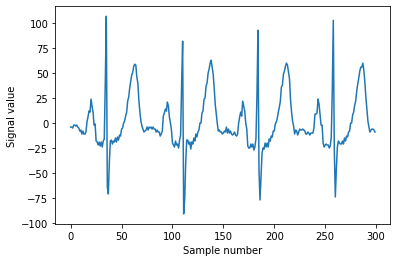

In [3]:
# IPython 'magic' command to set the matplotlib backend to display
# in the notebook
%matplotlib inline

import matplotlib.pyplot as plt

n_samples_to_plot = 300
plt.plot(ekg_data[0:n_samples_to_plot])
plt.xlabel("Sample number")
plt.ylabel("Signal value")
plt.show()

Since we have rather a lot of data, we'll take just the first 8,000 samples so our examples will run a bit faster:

In [4]:
ekg_data = ekg_data[0:8192]

## Windowing

The first step in our process is to split the waveform into overlapping segments, with the section of the original data sampled sliding along by two samples each time. We take this approach so that we get instances of each waveform shape with a variety of horizontal translations.

In [5]:
import numpy as np

segment_len = 32
slide_len = 2

segments = []
for start_pos in range(0, len(ekg_data), slide_len):
    end_pos = start_pos + segment_len
    # make a copy so changes to 'segments' doesn't modify the original ekg_data
    segment = np.copy(ekg_data[start_pos:end_pos])
    # if we're at the end and we've got a truncated segment, drop it
    if len(segment) != segment_len:
        continue
    segments.append(segment)

print("Produced %d waveform segments" % len(segments))

Produced 4081 waveform segments


(This code is saved for later reuse in `learn_utils.sliding_chunker`.)

Let's take a look at the segments we've produced:

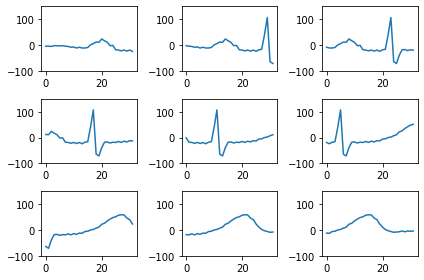

In [6]:
import learn_utils

learn_utils.plot_waves(segments, step=3)

Note that these segments do not necessarily begin and end with a value of zero. This could be a problem later on: since the learned "normal" segment will then also have non-zero starts and end, when we try to reconstruct our waveform to be tested by adding together our learned segment, we'll end up with discontinuities.

The way we avoid this problem is to apply a *window function* to the data, which forces the start and end to be zero. A simple window function we can apply is the first half of a sine wave:

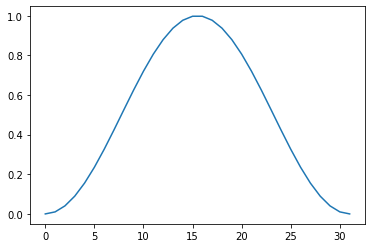

In [7]:
window_rads = np.linspace(0, np.pi, segment_len)
window = np.sin(window_rads)**2
plt.plot(window)
plt.show()

We then multiply each segment by this window function:

In [8]:
windowed_segments = []
for segment in segments:
    windowed_segment = np.copy(segment) * window
    windowed_segments.append(windowed_segment)

Plotting the result, we see the difference that the windowing process makes. The segments are now flat at the start and end - perfect to be joined together later.

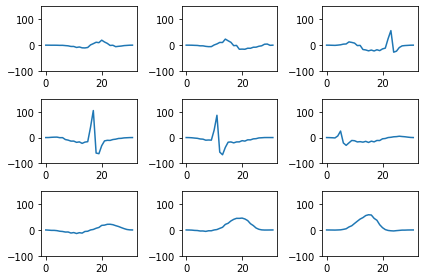

In [9]:
learn_utils.plot_waves(windowed_segments, step=3)

Note that windowing also has the effect of making the segments less affected by the waveform either side of the segment. The waveform shape represented by the segment is now more "concentrated" in the middle.

## Clustering

Next, we cluster our waveform segments in 32-dimensional space. The k-means algorithm is provided by Python's *scikit-learn* library.

In [10]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=150)
clusterer.fit(windowed_segments)

KMeans(n_clusters=150)

The cluster centroids are available through the `cluster_centers` attribute. Let's take a look to see what sort of shapes it's learned:

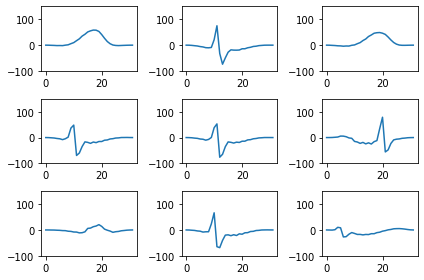

In [11]:
learn_utils.plot_waves(clusterer.cluster_centers_, step=15)

The clusterer appears to have learned a small number of basic shapes, with various horizontal translations. 

## Reconstruction from Clusters

Finally, we come to the interesting part of the algorithm: reconstructing our waveform to be tested using the learned library of shapes. Our approach is going to be very simple. We'll:

* Split the data into overlapping segments
* Find the cluster centroid which best matches our segment
* Use that centroid as the reconstruction for that segment
* Join the reconstruction segments up to form the reconstruction

This time, we only need enough overlap between segments to allow us to stitch the reconstructions back together again, so we'll go with an overlap of half a segment.

First, let's see how well we do at reconstructing the original waveform. We first form segments:

In [12]:
slide_len = segment_len/2
test_segments = learn_utils.sliding_chunker(
    ekg_data,
    window_len=segment_len,
    slide_len=slide_len
)

Before trying to reconstruct the whole thing, we can check how the reconstruction fares for individual segments. Try changing the segment index to see the reconstruction for different segments.

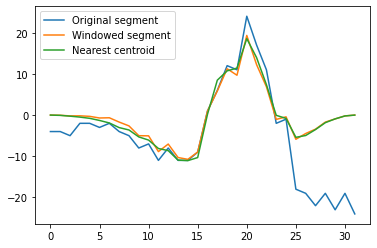

In [13]:
centroids = clusterer.cluster_centers_

segment = np.copy(test_segments[0])
# remember, the clustering was set up using the windowed data
# so to find a match, we should also window our search key
windowed_segment = segment * window
# predict() returns a list of centres to cope with the possibility of multiple
# samples being passed
nearest_centroid_idx = clusterer.predict(windowed_segment.reshape(1, -1))[0]
nearest_centroid = np.copy(centroids[nearest_centroid_idx])
plt.figure()
plt.plot(segment, label="Original segment")
plt.plot(windowed_segment, label="Windowed segment")
plt.plot(nearest_centroid, label="Nearest centroid")
plt.legend()
plt.show()

Looking good! So now, let's go ahead and try and reconstruct the full set of data.

Maximum reconstruction error was 12.4
98th percentile of reconstruction error was 5.7


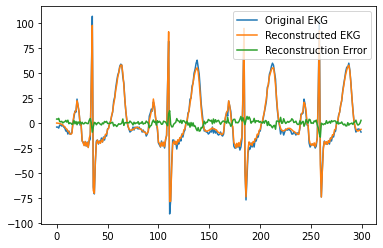

In [14]:
reconstruction = np.zeros(len(ekg_data))
slide_len = segment_len/2

for segment_n, segment in enumerate(test_segments):
    # don't modify the data in segments
    segment = np.copy(segment)
    segment *= window
    nearest_centroid_idx = clusterer.predict(segment.reshape(1, -1))[0]
    centroids = clusterer.cluster_centers_
    nearest_centroid = np.copy(centroids[nearest_centroid_idx])
    
    # overlay our reconstructed segments with an overlap of half a segment
    pos = int(segment_n * slide_len)
    reconstruction[pos:pos+segment_len] += nearest_centroid

n_plot_samples = 300

error = reconstruction[0:n_plot_samples] - ekg_data[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)
print("Maximum reconstruction error was %.1f" % error.max())
print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)

plt.plot(ekg_data[0:n_plot_samples], label="Original EKG")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed EKG")
plt.plot(error[0:n_plot_samples], label="Reconstruction Error")
plt.legend()
plt.show()

(This reconstruction code is stored in `learn_utils.reconstruct` for later reuse.)

The reconstruction is not bad at all!

## Anomaly Detection

Now that we're confident in our reconstruction algorithm, let's see what happens when we have an anomalous waveform. We'll introduce the anomaly manually by zeroing out a small number of samples of the original:

In [15]:
ekg_data_anomalous = np.copy(ekg_data)
ekg_data_anomalous[210:215] = 0

Then attempting a reconstruction of this data, using the same code as above:

Maximum reconstruction error was 55.3
98th percentile of reconstruction error was 9.5


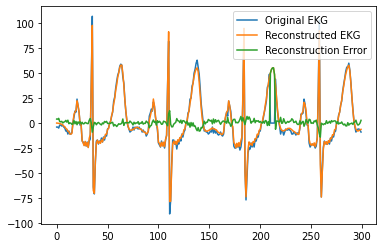

In [16]:
recontruction = \
    learn_utils.reconstruct(ekg_data_anomalous, window, clusterer)
    
error = reconstruction[0:n_plot_samples] - ekg_data_anomalous[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)
print("Maximum reconstruction error was %.1f" % error.max())
print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)

plt.plot(ekg_data_anomalous[0:n_plot_samples], label="Original EKG")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed EKG")
plt.plot(error[0:n_plot_samples], label="Reconstruction Error")
plt.legend()
plt.show()

Since our anomaly has produced a shape in the waveform that hadn't been seen before, the waveform around that point couldn't be reconstructed using the learned shape library. This gives a large, easily visible reconstruction error! This error could be easily detected using a simple threshold detector.

## Conclusion

We've looked at one example of the use of unsupervised learning techniques in systems administration: anomaly detection of time series data based on reconstruction error from k-means clustering.

This problem could have been solved in different ways. For example, we could have trained a predictive neural network model, and examined the difference between the predicted waveform and the actual waveform. In general, there is no 'one size fits all' solution in machine learning - different techniques will be required for different problems.

A standalone script containing our full set of code is available in this repository as `learn.py`.